## Text Classification- Deep Learning Approach
*author: Vikas Kumar (vikkumar@deloitte.com)*

References:
* https://torchtext.readthedocs.io/en/latest/vocab.html
* https://pytorch.org/tutorials/beginner/deep_learning_nlp_tutorial.html

### Typical components of deep learning approach for NLP
* `Preprocessing and tokenization`
* `Generating vocabulary of unique tokens and converting words to indices (Numericalization)`
* `Loading pretrained vectors e.g. Glove, Word2vec, Fasttext`
* `Padding text with zeros in case of variable lengths`
* `Dataloading and batching`
* `Model creation and training`
* `Prediction using trained Model`

This is good <PAD> <PAD>
This is good and awesome

In [1]:
from IPython.core.display import display, HTML
from IPython.display import Image
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
use_gpu = True
if use_gpu:
    assert torch.cuda.is_available(), 'You either do not have a GPU or is not accessible to PyTorch'

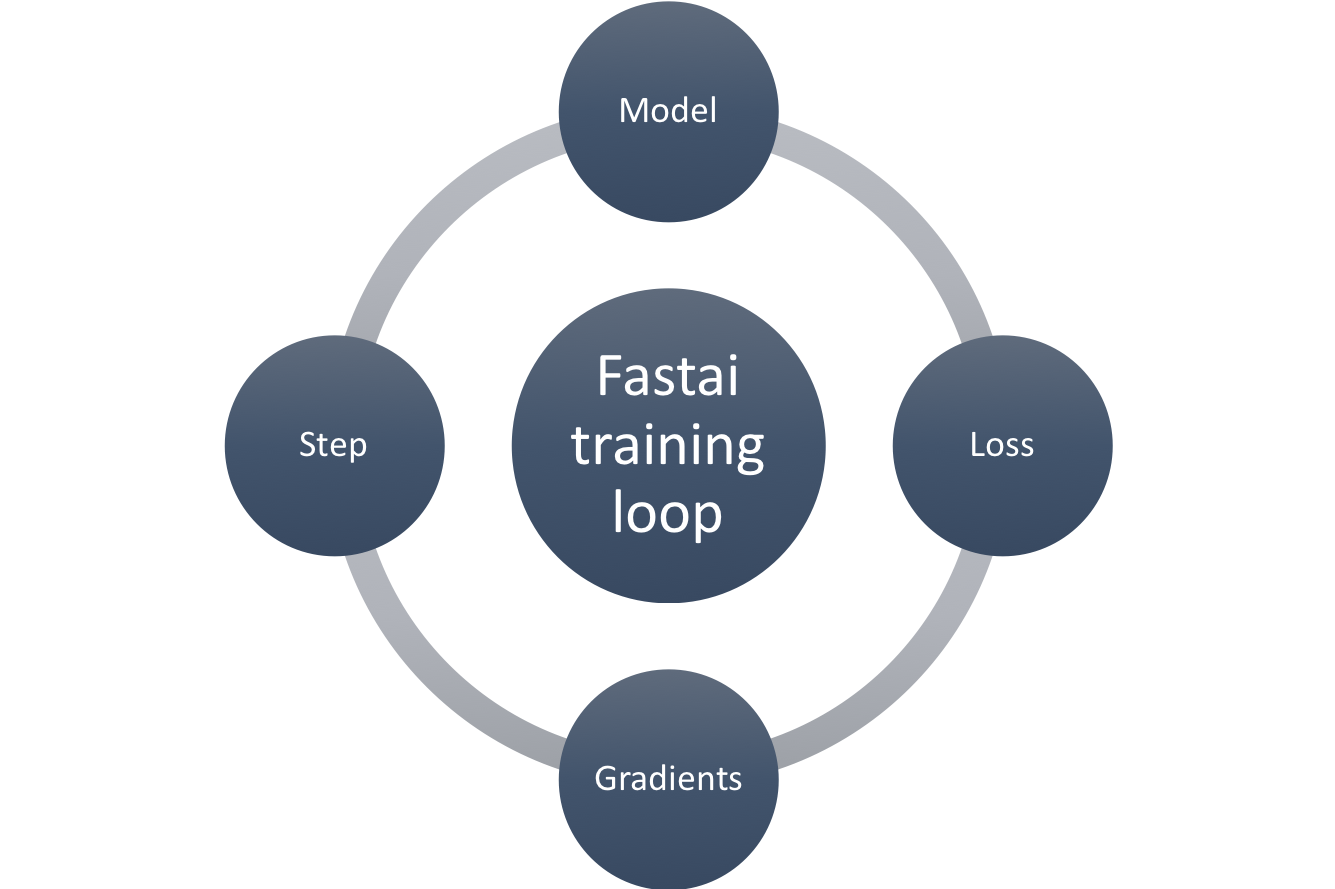

In [3]:
Image("https://pouannes.github.io/fastai-callbacks/fastai_training_loop_vanilla.png",height=400,width=600)

In [4]:
# def train(train_dl, model, epoch, opt, loss_func):
#   for _ in range(epoch):
#     model.train() # model in training mode
#     for xb,yb in train_dl: # loop through the batches 
#       out = model(xb) # forward pass 
#       loss = loss_func(out, yb) # compute the loss
#       loss.backward() # backward pass gradient 
#       opt.step() # update the gradient 
#       opt.zero_grad() 

In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/usinlppracticum/imdb_test.csv
/kaggle/input/usinlppracticum/sample_submission.csv
/kaggle/input/usinlppracticum/imdb_train.csv
/kaggle/input/glove6b/glove.6B.300d.txt
/kaggle/input/glove6b/glove.6B.200d.txt
/kaggle/input/glove6b/glove.6B.50d.txt
/kaggle/input/glove6b/glove.6B.100d.txt


### Sigmoid Function

In [6]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

#### Data Loaders with torchtext

In [7]:
from torchtext.data import Field
tokenize = lambda x: x.split()
txt_field = Field(sequential=True, tokenize=tokenize, lower=True)

label_field = Field(sequential=False, use_vocab=False)

In [8]:
train=pd.read_csv('/kaggle/input/usinlppracticum/imdb_train.csv')
train.head()

,review,sentiment
0,We had STARZ free weekend and I switched on th...,negative
1,I'll admit that this isn't a great film. It pr...,negative
2,I finally found a version of Persuasion that I...,positive
3,The BBC surpassed themselves with the boundari...,positive
4,"Much praise has been lavished upon Farscape, b...",negative


In [9]:
train['sentiment']=train['sentiment'].map({'negative':0,'positive':1})

In [10]:
print({'negative':0,'positive':1})

{'negative': 0, 'positive': 1}


In [11]:
train.head()

,review,sentiment
0,We had STARZ free weekend and I switched on th...,0
1,I'll admit that this isn't a great film. It pr...,0
2,I finally found a version of Persuasion that I...,1
3,The BBC surpassed themselves with the boundari...,1
4,"Much praise has been lavished upon Farscape, b...",0


In [12]:
train.to_csv('train.csv',index=False)

In [13]:
from torchtext.data import TabularDataset
tv_datafields = [
                 ("review", txt_field), ("sentiment", label_field)]

trn = TabularDataset( path="train.csv", # the root directory where the data lies
#                train='imdb_train.csv',
               format='csv',
               skip_header=True, # if your csv header has a header, make sure to pass this to ensure it doesn't get proceesed as data!
               fields=tv_datafields)

### train and validation split 

In [14]:
trn,val = trn.split(split_ratio=0.9, stratified=False, strata_field='sentiment', random_state=None)

In [15]:
pd.read_csv("/kaggle/input/usinlppracticum/imdb_test.csv").head()

,id,review
0,1,Not only is this movie a great film for basic ...
1,2,"Waitress: Honey, here's them eggs you ordered...."
2,3,Many mystery stories follow the standard whodu...
3,4,A space ship cruising through the galaxy encou...
4,5,My favorite film this year. Great characters a...


In [16]:
tst_datafields = [("id", None), # we won't be needing the id, so we pass in None as the field
                 ("review", txt_field)
                 ]
tst = TabularDataset(
        path="/kaggle/input/usinlppracticum/imdb_test.csv", # the file path
        format='csv',
        skip_header=True, # if your csv header has a header, make sure to pass this to ensure it doesn't get proceesed as data!
        fields=tst_datafields)

In [17]:
len(trn), len(val),len(tst)

(36000, 4000, 10000)

### Exploring the Dataset Objects

In [18]:
trn.fields.items()

dict_items([('review', <torchtext.data.field.Field object at 0x7fcd0233f320>), ('sentiment', <torchtext.data.field.Field object at 0x7fcd0233f358>)])

In [19]:
ex = trn[1]
type(ex)

torchtext.data.example.Example

In [20]:
trn[0].__dict__.keys()

dict_keys(['review', 'sentiment'])

In [21]:
trn[0].__dict__['review'][:10]

['people',
 'call',
 'this',
 'a',
 'comedy,',
 'but',
 'when',
 'i',
 'just',
 'watched']

In [22]:
ex.review

['michael',
 'radford',
 'has',
 'done',
 'an',
 'excellent',
 'job',
 'bringing',
 'this',
 'difficult',
 'play',
 'to',
 'the',
 'screen.',
 'he',
 'has',
 'taken',
 'a',
 'play',
 'with',
 'a',
 'reputation',
 'for',
 'anti-semitism,',
 'and',
 'shown',
 'us',
 'that',
 'shakespeare',
 'knew',
 'quite',
 'well',
 'the',
 'humanity',
 'of',
 'the',
 'jews.',
 'radford',
 'said',
 'after',
 'the',
 'screening,',
 'and',
 'i',
 'agree,',
 'that',
 'shylock',
 'is',
 'his',
 'first',
 'tragic',
 'hero,',
 'the',
 'first',
 'of',
 'his',
 'characters',
 'to',
 'be',
 'undone',
 'by',
 'a',
 'driving,',
 'compulsive',
 'need',
 'for',
 'revenge.',
 'he',
 'also',
 'points',
 'out,',
 'quite',
 'rightly,',
 'that',
 'a',
 'man',
 'who',
 'was',
 'anti-semitic',
 'could',
 'not',
 'have',
 'written',
 "shylock's",
 'speech',
 'of',
 '"if',
 'you',
 'prick',
 'me,',
 'do',
 'i',
 'not',
 'bleed?"',
 'radford',
 'is',
 'himself',
 'of',
 'jewish',
 'descent',
 'and',
 'he',
 'has',
 'picked',

In [23]:
ex.sentiment

'1'

### loading pretrained Vectors & Creating Vocab

In [24]:
from torchtext import vocab
# specify the path to the localy saved vectors
vec = vocab.Vectors('/kaggle/input/glove6b/glove.6B.300d.txt',cache= '/kaggle/working')
# build the vocabulary using train and validation dataset and assign the vectors
# print('creating Vocab')


100%|█████████▉| 399894/400000 [01:25<00:00, 4460.21it/s]

In [25]:
txt_field.build_vocab(trn, max_size=60000, vectors=vec)
# build vocab for labels
label_field.build_vocab(trn)

In [26]:
pre_trained_vectors=txt_field.vocab.vectors
pre_trained_vectors.shape

torch.Size([60002, 300])

In [27]:
txt_field.vocab.vectors[txt_field.vocab.stoi['the']].shape

torch.Size([300])

In [28]:
txt_field.vocab.freqs.most_common(14)

[('the', 459596),
 ('a', 228181),
 ('and', 226060),
 ('of', 206417),
 ('to', 190560),
 ('is', 147200),
 ('in', 129755),
 ('i', 102034),
 ('this', 99618),
 ('that', 93564),
 ('it', 93387),
 ('/><br', 72313),
 ('was', 67226),
 ('as', 63755)]

In [29]:
type(txt_field.vocab.itos), type(txt_field.vocab.stoi), len(txt_field.vocab.itos), len(txt_field.vocab.stoi.keys()),

(list, collections.defaultdict, 60002, 60002)

In [30]:
txt_field.vocab.stoi['and'], txt_field.vocab.itos[4]

(4, 'and')

* `Preprocessing and tokenization`
* `Generating vocabulary of unique tokens and converting words to indices (Numericalization)`
* `Loading pretrained vectors e.g. Glove, Word2vec, Fasttext`
* Padding text with zeros in case of variable lengths
* Dataloading and batching
* Model creation and training
* Prediction using trained Model


### Iterators
* `Padding text with zeros in case of variable lengths`
* `Dataloading and batching`

In [31]:
from torchtext.data import Iterator,BucketIterator
traindl, valdl = BucketIterator.splits(datasets=(trn, val), # specify train and validation Tabulardataset
                                            batch_sizes=(64,64),  # batch size of train and validation
                                            sort_key=lambda x: len(x.review), # on what attribute the text should be sorted
                                            device=None, # -1 mean cpu and 0 or None mean gpu
                                            sort_within_batch=False, 
                                            repeat=False)

In [32]:
test_iter = Iterator(tst, batch_size=64, sort=False, sort_within_batch=False, repeat=False)

In [33]:
print(len(traindl), len(valdl))

563 63


In [34]:
batch = next(iter(traindl)) # BucketIterator return a batch object
print(type(batch))

<class 'torchtext.data.batch.Batch'>


In [35]:
print(batch.sentiment) # labels of the batch
# tensor([ 0,  0,  0], device='cuda:0')

tensor([0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1,
        1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1,
        0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1])


In [36]:
print(batch.review.shape) # text index and length of the batch

torch.Size([639, 64])


In [37]:
class BatchGenerator:
    def __init__(self, dl, x_field, y_field):
        self.dl, self.x_field, self.y_field = dl, x_field, y_field
        
    def __len__(self):
        return len(self.dl)
    
    def __iter__(self):
        for batch in self.dl:
            X = getattr(batch, self.x_field)
            if self.y_field is not None:
                y = getattr(batch, self.y_field)
            else:
                y = torch.zeros((1))
            y= torch.tensor(y[:, np.newaxis], dtype=torch.float32)
            if use_gpu:
                yield (X.cuda(), y.cuda())
            else:
                yield (X, y)
          

In [38]:
train_batch_it = BatchGenerator(traindl, 'review', 'sentiment')
val_batch_it = BatchGenerator(valdl, 'review', 'sentiment')
test_dl = BatchGenerator(test_iter, "review", None)
# print(next(iter(train_batch_it))shape)

In [39]:
vocab_size = len(txt_field.vocab)
n_out = 1
vocab_size

60002

In [40]:
trn.fields['review'].vocab.vectors.shape

torch.Size([60002, 300])

In [41]:
# class SimpleLSTMBaseline(nn.Module):
#     def __init__(self, hidden_dim, emb_dim=300,pretrained_vec=None,
#                  spatial_dropout=0.05, recurrent_dropout=0.1, num_linear=2):
#         super().__init__() # don't forget to call this!
#         self.embedding = nn.Embedding(len(txt_field.vocab), emb_dim)
#         self.embedding.weight.data.copy_(pretrained_vec) # load pretrained vectors
#         self.embedding.weight.requires_grad = False # make embedding non trainable
#         self.embedding_dropout = nn.Dropout2d(0.1)
#         self.lstm_1 = nn.LSTM(emb_dim, hidden_dim, bidirectional=True)
#         self.lstm_2 = nn.LSTM(hidden_dim*2, hidden_dim, bidirectional=True)
#         self.linear = nn.Linear(hidden_dim, hidden_dim//4)
#         self.relu = nn.ReLU()
#         self.dropout = nn.Dropout(0.1)
#         self.out = nn.Linear(hidden_dim//4, 1)
# #         self.predictor = nn.Linear(hidden_dim, 1)
    
#     def forward(self, seq):
#         h_embedding = self.embedding(x)
#         hdn, _ = self.encoder(self.embedding(seq))
#         feature = hdn[-1, :, :]
#         for layer in self.linear_layers:
#             feature = layer(feature)
#         preds = self.predictor(feature)
#         return preds

### Model Architecture

In [42]:
class SimpleLSTM(nn.Module):
    def __init__(self):
        super(SimpleLSTM, self).__init__()
        
        hidden_size = 128
        max_features,embed_size=60002,300
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(pre_trained_vectors, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        
#         self.embedding_dropout = nn.Dropout2d(0.1)
        self.lstm_1 = nn.LSTM(embed_size, hidden_size, bidirectional=True)
        self.lstm_2 = nn.LSTM(hidden_size*2, hidden_size, bidirectional=True)
        self.linear = nn.Linear(hidden_size*6, 16)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.1)
        self.out = nn.Linear(16, 1)
    def forward(self, x):
        h_embedding = self.embedding(x)
#             h_embedding = torch.squeeze(self.embedding_dropout(torch.unsqueeze(h_embedding, 0)))

        h_lstm_1, _ = self.lstm_1(h_embedding)
        h_lstm_2, _ = self.lstm_2(h_lstm_1)

        avg_pool = torch.mean(h_lstm_1, 0)
        max_pool, _ = torch.max(h_lstm_2, 0)

        conc = torch.cat((h_lstm_2[-1,:,:], avg_pool, max_pool), 1)# 128*2, 128*2, 128*2
        conc = self.relu(self.linear(conc))
        conc = self.dropout(conc)
        out = self.out(conc)

        return out

In [43]:
x,y=next(iter(train_batch_it))
x.shape

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
100%|█████████▉| 399894/400000 [01:40<00:00, 4460.21it/s]

torch.Size([818, 64])

In [44]:
m=SimpleLSTM()
m.cuda()
m

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


SimpleLSTM(
  (embedding): Embedding(60002, 300)
  (lstm_1): LSTM(300, 128, bidirectional=True)
  (lstm_2): LSTM(256, 128, bidirectional=True)
  (linear): Linear(in_features=768, out_features=16, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (out): Linear(in_features=16, out_features=1, bias=True)
)

In [45]:
em_sz = 300
# nh = 256/
model = SimpleLSTM()
if use_gpu:
    model = model.cuda()
print(model)

SimpleLSTM(
  (embedding): Embedding(60002, 300)
  (lstm_1): LSTM(300, 128, bidirectional=True)
  (lstm_2): LSTM(256, 128, bidirectional=True)
  (linear): Linear(in_features=768, out_features=16, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (out): Linear(in_features=16, out_features=1, bias=True)
)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [46]:
def model_size(model: torch.nn)->int:
    """
    Calculates the number of trainable parameters in any model
    
    Returns:
        params (int): the total count of all model weights
    """
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
#     model_parameters = model.parameters()
    params = sum([np.prod(p.size()) for p in model_parameters])
    return params

print(f'{model_size(model)/10**6} million parameters')

0.847905 million parameters


### optimizer and loss function 

In [47]:
from torch import optim
opt = optim.Adam(model.parameters(), lr=1e-2)
loss_func = nn.BCEWithLogitsLoss().cuda()
epochs = 10

In [48]:
next(iter(traindl))


[torchtext.data.batch.Batch of size 64]
	[.review]:[torch.LongTensor of size 766x64]
	[.sentiment]:[torch.LongTensor of size 64]

In [49]:
model=SimpleLSTM()
model.cuda()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


SimpleLSTM(
  (embedding): Embedding(60002, 300)
  (lstm_1): LSTM(300, 128, bidirectional=True)
  (lstm_2): LSTM(256, 128, bidirectional=True)
  (linear): Linear(in_features=768, out_features=16, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (out): Linear(in_features=16, out_features=1, bias=True)
)

In [50]:
x.shape

torch.Size([818, 64])

In [51]:
x,y=next(iter(train_batch_it))
model(x.cuda()).shape

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app


torch.Size([64, 1])

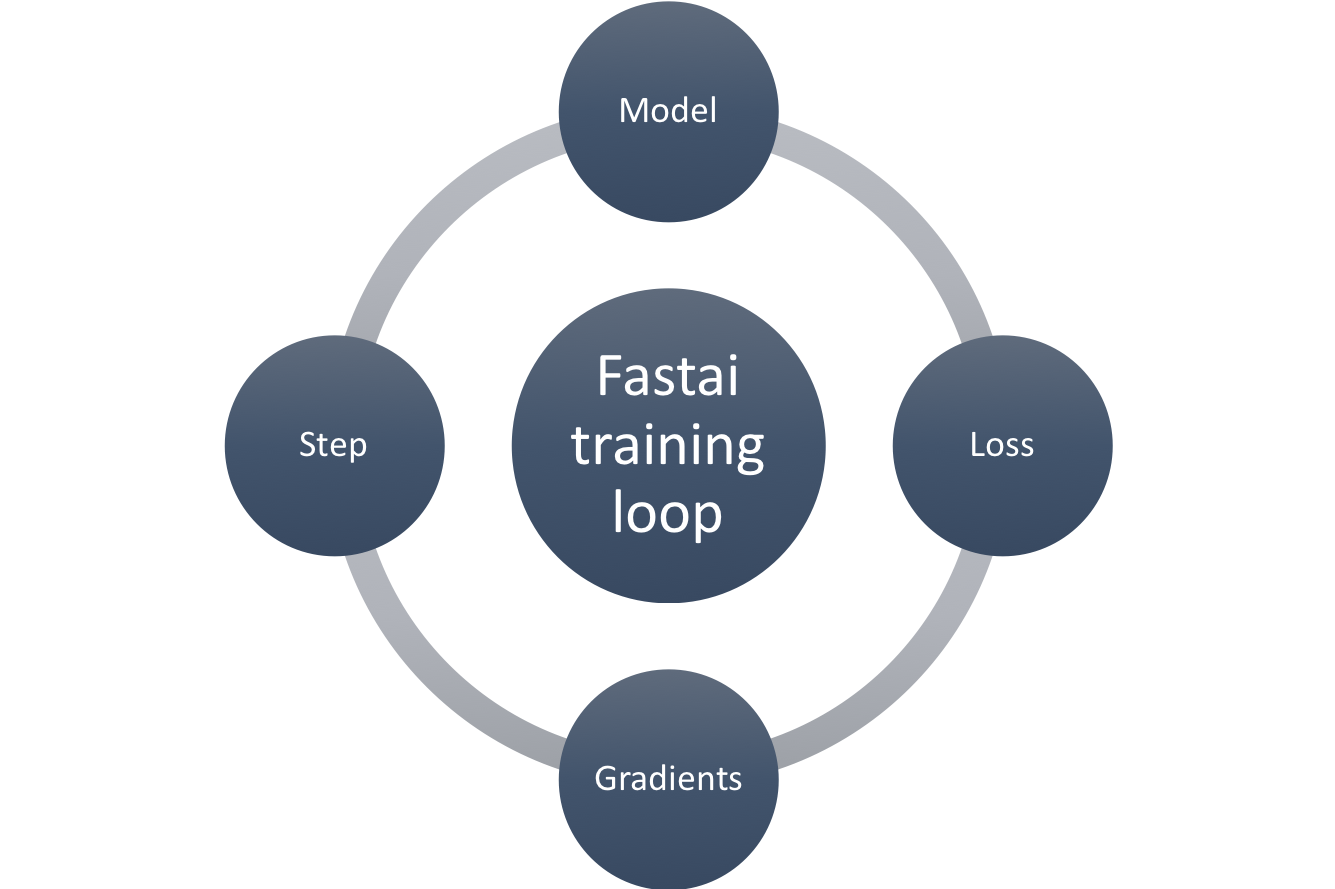

In [52]:
Image("https://pouannes.github.io/fastai-callbacks/fastai_training_loop_vanilla.png",height=400,width=600)

### Training a Text Classifier- LSTM

In [53]:

from tqdm import tqdm
for epoch in tqdm(range(1, epochs + 1)):
    running_loss = 0.0
    model.train() # turn on training mode
    for x, y in train_batch_it: # thanks to our wrapper, we can intuitively iterate over our data!
        preds = model(x)
#         print(preds.dtype,y.dtype)
        loss = loss_func(preds, y)
        loss.backward()
        opt.step()
        opt.zero_grad()
        #---
        running_loss += loss.item() * x.size(0)
    epoch_loss = running_loss / len(trn)
    # calculate the validation loss for this epoch
    val_loss = 0.0
    val_acc=0
    model.eval() # turn on evaluation mode
    with torch.no_grad():
        for x, y in val_batch_it:
            preds = model(x)
            y_pred = sigmoid(preds.detach().cpu().numpy()).astype(int)
            loss = loss_func(preds, y)
            val_loss += loss.item() * x.size(0)
#             out = (sigmoid(preds>0.5))
            
            val_acc += (y_pred == y.cpu().numpy().astype(int)).sum().item()
        val_loss /= len(val)
        val_acc=val_acc/len(val)
    print('Epoch: {}, Training Loss: {:.4f}, Validation Loss: {:.4f},val_acc:{:.4f}'.format(epoch, epoch_loss, val_loss,val_acc))


  0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app

 10%|█         | 1/10 [01:33<14:01, 93.55s/it]

Epoch: 1, Training Loss: 9.5088, Validation Loss: 2.7094,val_acc:0.4888



 20%|██        | 2/10 [03:07<12:28, 93.55s/it]

Epoch: 2, Training Loss: 9.5132, Validation Loss: 2.7094,val_acc:0.4888



 30%|███       | 3/10 [04:41<10:56, 93.76s/it]

Epoch: 3, Training Loss: 9.5229, Validation Loss: 2.7094,val_acc:0.4888



 40%|████      | 4/10 [06:14<09:21, 93.62s/it]

Epoch: 4, Training Loss: 9.5189, Validation Loss: 2.7094,val_acc:0.4888



 50%|█████     | 5/10 [07:47<07:46, 93.37s/it]

Epoch: 5, Training Loss: 9.4777, Validation Loss: 2.7094,val_acc:0.4888



 60%|██████    | 6/10 [09:22<06:15, 93.77s/it]

Epoch: 6, Training Loss: 9.5740, Validation Loss: 2.7094,val_acc:0.4888



 70%|███████   | 7/10 [10:56<04:41, 93.81s/it]

Epoch: 7, Training Loss: 9.5693, Validation Loss: 2.7094,val_acc:0.4888



 80%|████████  | 8/10 [12:29<03:07, 93.56s/it]

Epoch: 8, Training Loss: 9.5523, Validation Loss: 2.7094,val_acc:0.4888



 90%|█████████ | 9/10 [14:03<01:33, 93.89s/it]

Epoch: 9, Training Loss: 9.6196, Validation Loss: 2.7094,val_acc:0.4888



100%|██████████| 10/10 [15:36<00:00, 93.68s/it]

Epoch: 10, Training Loss: 9.5402, Validation Loss: 2.7094,val_acc:0.4888


In [54]:
next(iter(test_dl))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app


(tensor([[    0, 13846,    15,  ...,     8,    12,    12],
         [  118,     2,     3,  ...,     2,   247,     7],
         [    0, 11944,   564,  ...,   396,    15,    30],
         ...,
         [    1,     1,     1,  ...,     1,     1,     1],
         [    1,     1,     1,  ...,     1,     1,     1],
         [    1,     1,     1,  ...,     1,     1,     1]], device='cuda:0'),
 tensor([[0.]], device='cuda:0'))

In [55]:
model.eval()

SimpleLSTM(
  (embedding): Embedding(60002, 300)
  (lstm_1): LSTM(300, 128, bidirectional=True)
  (lstm_2): LSTM(256, 128, bidirectional=True)
  (linear): Linear(in_features=768, out_features=16, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (out): Linear(in_features=16, out_features=1, bias=True)
)

### Prediction using trained Model

In [56]:
with torch.no_grad():
    test_preds = []
    for x, y in tqdm(test_dl):
        preds = model(x)
        # if you're data is on the GPU, you need to move the data back to the cpu
        # preds = preds.data.cpu().numpy()
        preds = preds.data.cpu().numpy()
        # the actual outputs of the model are logits, so we need to pass these values to the sigmoid function
        preds = 1 / (1 + np.exp(-preds))
    #     print(preds.shape)
        test_preds.append(preds[:,0])
    test_preds = np.hstack(test_preds)


  0%|          | 0/157 [00:00<?, ?it/s]/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app

100%|██████████| 157/157 [00:11<00:00, 13.39it/s]


In [57]:
test_df = pd.read_csv("/kaggle/input/usinlppracticum/imdb_test.csv")
test_df['sentiment'] = np.where(test_preds>0.5,'positive','negative')


In [58]:
test_df.head()

,id,review,sentiment
0,1,Not only is this movie a great film for basic ...,positive
1,2,"Waitress: Honey, here's them eggs you ordered....",positive
2,3,Many mystery stories follow the standard whodu...,positive
3,4,A space ship cruising through the galaxy encou...,positive
4,5,My favorite film this year. Great characters a...,positive


In [59]:
test_df.sentiment.value_counts()

positive    10000
Name: sentiment, dtype: int64